In [3]:
import matplotlib.pyplot as plt
import copy
import numpy as np
from torchvision import datasets, transforms
import torch
import pandas as pd

from utils.sampling import mnist_iid, mnist_noniid, cifar_iid, cifar_noniid
from utils.options import args_parser
from models.Update import LocalUpdate
from models.Nets import MLP, CNNMnist, CNNCifar, MobileNetCifar, CNN
from models.Fed import FedAvg
from models.test import test_img

import csv
import os

In [5]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True
np.random.seed(0)


In [48]:
trans_cifar10_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
trans_cifar100_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.507, 0.487, 0.441],
                                                               std=[0.267, 0.256, 0.276])])
trans_cifar100_val = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.507, 0.487, 0.441],
                                                              std=[0.267, 0.256, 0.276])])

dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar10_train)
dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar10_val)

dict_users = cifar_noniid(dataset_train, 100, partition="label2")

Files already downloaded and verified
Files already downloaded and verified


In [49]:
user_label_dict = {}

In [50]:
for i in range(100):
    user_label_dict[i] = {i: 0 for i in range(10)}
    
    for d in dict_users[i]:
        user_label_dict[i][dataset_train[d][1]] += 1

In [51]:
user_label_dict[0]

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 250, 6: 250, 7: 0, 8: 0, 9: 0}

In [52]:
data_dict = {}
for label in range(10):
    data_dict["Label-{}".format(label)] = [user_label_dict[i][label] for i in range(100)]

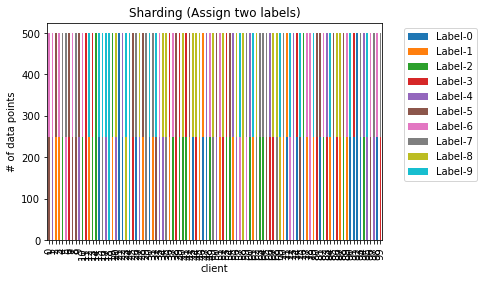

In [53]:
plotdata = pd.DataFrame(data_dict, index=[i for i in range(100)])
plotdata.plot(kind='bar', stacked=True)
plt.title("Sharding (Assign two labels)")
plt.xlabel("client")
plt.ylabel("# of data points")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [54]:
def cifar_noniid(dataset, num_users, partition, beta=0.0):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    if partition == "label2":
        num_shards, num_imgs = 200, 250
        idx_shard = [i for i in range(num_shards)]
        dict_users = {i: np.array([]) for i in range(num_users)}
        idxs = np.arange(num_shards*num_imgs)
        labels = np.array([d[1] for d in dataset], dtype=np.int)

        # sort labels
        idxs_labels = np.vstack((idxs, labels))
        idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
        idxs = idxs_labels[0, :]

        # divide and assign
        for i in range(num_users):
            rand_set = set(np.random.choice(idx_shard, 2, replace=False))
            idx_shard = list(set(idx_shard) - rand_set)
            for rand in rand_set:
                dict_users[i] = np.concatenate((dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)

        # data type cast 
        for i in range(num_users):
            dict_users[i] = dict_users[i].astype('int').tolist()
    
    elif partition == 'labeldir': 
        min_size = 0
        min_require_size = 10
        K = 10
        n_parties = num_users

        N = len(dataset)
        dict_users = {}
        
        y_train = []

        for i in range(K):
            y_train += [i] * int(N / K)
        y_train = np.array(y_train)

        while min_size < min_require_size:
            idx_batch = [[] for _ in range(n_parties)]
            for k in range(K):
                idx_k = np.where(y_train == k)[0]

                np.random.shuffle(idx_k)
                proportions = np.random.dirichlet(np.repeat(beta, n_parties))

                proportions = np.array([p * (len(idx_j) < N / n_parties) for p, idx_j in zip(proportions, idx_batch)])

                proportions = proportions / proportions.sum()

                proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]

                idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]

                min_size = min([len(idx_j) for idx_j in idx_batch])


        for j in range(n_parties):
            np.random.shuffle(idx_batch[j])
            dict_users[j] = idx_batch[j]
    
    return dict_users

In [55]:
trans_cifar10_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
trans_cifar100_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.507, 0.487, 0.441],
                                                               std=[0.267, 0.256, 0.276])])
trans_cifar100_val = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.507, 0.487, 0.441],
                                                              std=[0.267, 0.256, 0.276])])

dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar10_train)
dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar10_val)

dict_users = cifar_noniid(dataset_train, 100, partition="labeldir", beta=0.5)

Files already downloaded and verified
Files already downloaded and verified


In [56]:
user_label_dict = {}

In [57]:
for i in range(100):
    user_label_dict[i] = {i: 0 for i in range(10)}
    
    for d in dict_users[i]:
        user_label_dict[i][dataset_train[d][1]] += 1

In [58]:
data_dict = {}
for label in range(10):
    data_dict["Label-{}".format(label)] = [user_label_dict[i][label] for i in range(100)]

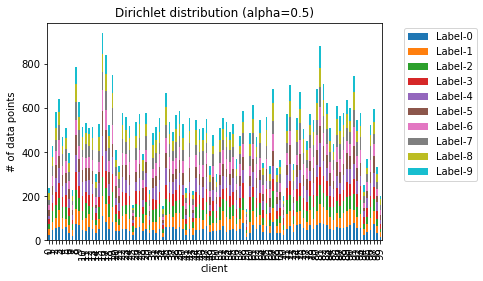

In [59]:
plotdata = pd.DataFrame(data_dict, index=[i for i in range(100)])
plotdata.plot(kind='bar', stacked=True)
plt.title("Dirichlet distribution (alpha=0.5)")
plt.xlabel("client")
plt.ylabel("# of data points")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [60]:
trans_cifar10_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
trans_cifar100_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.507, 0.487, 0.441],
                                                               std=[0.267, 0.256, 0.276])])
trans_cifar100_val = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.507, 0.487, 0.441],
                                                              std=[0.267, 0.256, 0.276])])

dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar10_train)
dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar10_val)

dict_users = cifar_noniid(dataset_train, 100, partition="labeldir", beta=1.0)

Files already downloaded and verified
Files already downloaded and verified


In [61]:
user_label_dict = {}

In [62]:
for i in range(100):
    user_label_dict[i] = {i: 0 for i in range(10)}
    
    for d in dict_users[i]:
        user_label_dict[i][dataset_train[d][1]] += 1

In [63]:
data_dict = {}
for label in range(10):
    data_dict["Label-{}".format(label)] = [user_label_dict[i][label] for i in range(100)]

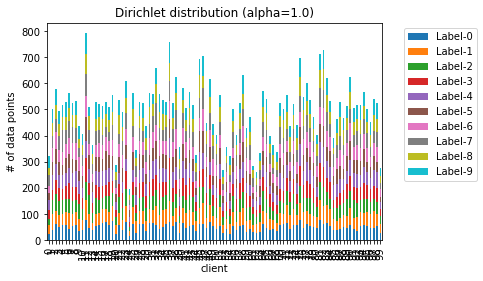

In [65]:
plotdata = pd.DataFrame(data_dict, index=[i for i in range(100)])
plotdata.plot(kind='bar', stacked=True)
plt.title("Dirichlet distribution (alpha=1.0)")
plt.xlabel("client")
plt.ylabel("# of data points")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [66]:
trans_cifar10_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                       std=[0.229, 0.224, 0.225])])
trans_cifar10_val = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                             std=[0.229, 0.224, 0.225])])
trans_cifar100_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                          transforms.RandomHorizontalFlip(),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.507, 0.487, 0.441],
                                                               std=[0.267, 0.256, 0.276])])
trans_cifar100_val = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.507, 0.487, 0.441],
                                                              std=[0.267, 0.256, 0.276])])

dataset_train = datasets.CIFAR10('./data/cifar', train=True, download=True, transform=trans_cifar10_train)
dataset_test = datasets.CIFAR10('./data/cifar', train=False, download=True, transform=trans_cifar10_val)

dict_users = cifar_noniid(dataset_train, 100, partition="labeldir", beta=100.0)

Files already downloaded and verified
Files already downloaded and verified


In [67]:
user_label_dict = {}

In [68]:
for i in range(100):
    user_label_dict[i] = {i: 0 for i in range(10)}
    
    for d in dict_users[i]:
        user_label_dict[i][dataset_train[d][1]] += 1

In [69]:
data_dict = {}
for label in range(10):
    data_dict["Label-{}".format(label)] = [user_label_dict[i][label] for i in range(100)]

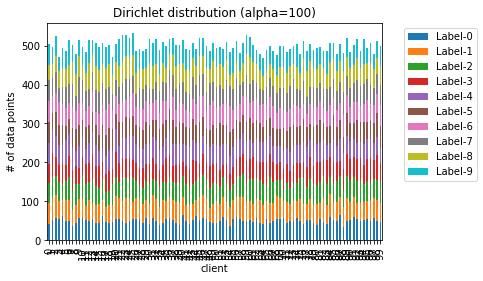

In [71]:
plotdata = pd.DataFrame(data_dict, index=[i for i in range(100)])
plotdata.plot(kind='bar', stacked=True)
plt.title("Dirichlet distribution (alpha=100)")
plt.xlabel("client")
plt.ylabel("# of data points")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')